# PYSPARK MLOPs

Here I will go through the basic operations of the MLOps library for Spark.

As always, let us create a Spark session and load the dataset.
Dataset from: https://www.kaggle.com/datasets/uciml/mushroom-classification

In [1]:
from pyspark.sql import SparkSession

spark = (
   SparkSession.builder.appName('Spark Demo') 
  .master('local[*]') #local[*] - Run Spark locally with as many worker threads as logical cores on your machine. I could choose any number really
                    # YARN when deploying to a cluster with YARN
  .config("spark.sql.execution.arrow.maxRecordsPerBatch", "100")  # For testing purposes
  .getOrCreate()
)

data_path = 'data/mushrooms.csv'
mush_df = spark.read.csv(data_path, inferSchema=True, header=True)
mush_df.printSchema()


25/04/24 14:28:10 WARN Utils: Your hostname, alejandro resolves to a loopback address: 127.0.1.1; using 192.168.3.37 instead (on interface wlp2s0)
25/04/24 14:28:10 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/24 14:28:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


root
 |-- class: string (nullable = true)
 |-- cap-shape: string (nullable = true)
 |-- cap-surface: string (nullable = true)
 |-- cap-color: string (nullable = true)
 |-- bruises: string (nullable = true)
 |-- odor: string (nullable = true)
 |-- gill-attachment: string (nullable = true)
 |-- gill-spacing: string (nullable = true)
 |-- gill-size: string (nullable = true)
 |-- gill-color: string (nullable = true)
 |-- stalk-shape: string (nullable = true)
 |-- stalk-root: string (nullable = true)
 |-- stalk-surface-above-ring: string (nullable = true)
 |-- stalk-surface-below-ring: string (nullable = true)
 |-- stalk-color-above-ring: string (nullable = true)
 |-- stalk-color-below-ring: string (nullable = true)
 |-- veil-type: string (nullable = true)
 |-- veil-color: string (nullable = true)
 |-- ring-number: string (nullable = true)
 |-- ring-type: string (nullable = true)
 |-- spore-print-color: string (nullable = true)
 |-- population: string (nullable = true)
 |-- habitat: string 

Important imports

In [2]:
from pyspark.sql import functions as F

Let's make sure there are no import values

In [3]:
# Number of nan values
null_df = mush_df.select(*[F.count(F.when(F.col(c).isNull() | F.isnan(F.col(c)), c)).alias(c) for c in mush_df.columns]) # I'll be honest, I copied this one from the internet
null_df.show()

[Stage 2:>                                                          (0 + 1) / 1]

+-----+---------+-----------+---------+-------+----+---------------+------------+---------+----------+-----------+----------+------------------------+------------------------+----------------------+----------------------+---------+----------+-----------+---------+-----------------+----------+-------+
|class|cap-shape|cap-surface|cap-color|bruises|odor|gill-attachment|gill-spacing|gill-size|gill-color|stalk-shape|stalk-root|stalk-surface-above-ring|stalk-surface-below-ring|stalk-color-above-ring|stalk-color-below-ring|veil-type|veil-color|ring-number|ring-type|spore-print-color|population|habitat|
+-----+---------+-----------+---------+-------+----+---------------+------------+---------+----------+-----------+----------+------------------------+------------------------+----------------------+----------------------+---------+----------+-----------+---------+-----------------+----------+-------+
|    0|        0|          0|        0|      0|   0|              0|           0|        0|   

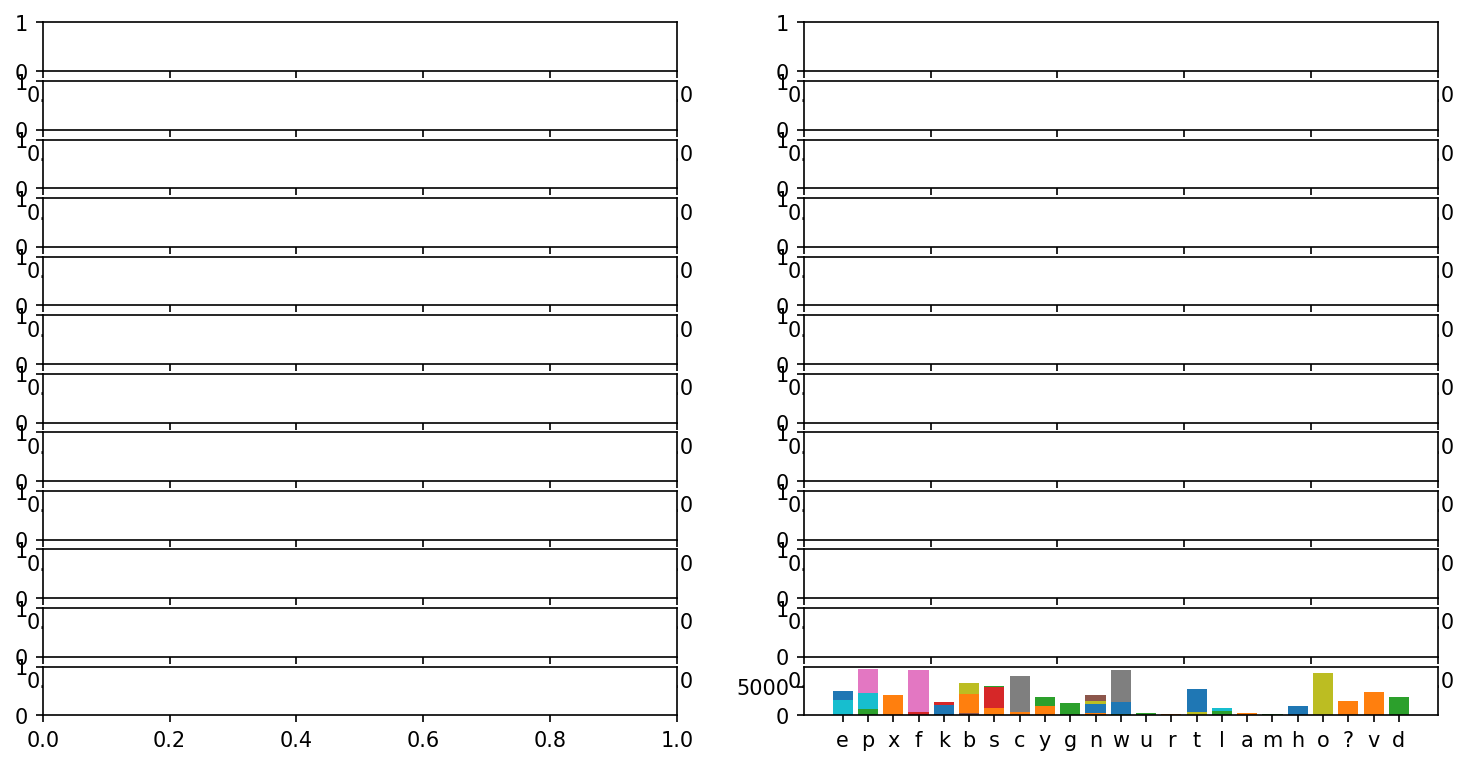

In [24]:
import math
# Plot data distribution of a column
from matplotlib import pyplot as plt
from itertools import product
%matplotlib inline
plt.rcParams['figure.dpi'] = 150

def plot_column_dist(df, col, ax=None):
    if ax is None:
        ax = plt.gca()
    agg_df = df.groupBy(col).agg(F.count('*').alias('count')).toPandas()
    agg_df = agg_df.sort_values('count', ascending=False)
    plt.bar(agg_df[agg_df.columns[0]], agg_df['count'])
    
def plot_columns_dist(df, cols, figrows, figcols, size=(12, 6)):
    assert len(cols) <= figrows * figcols
    fig, axs = plt.subplots(figrows, figcols, figsize=size)
    for i, j in product(range(figrows), range(figcols)):
        if i*figcols + j >= len(cols):
            break
        col = cols[i*figcols + j]
        plot_column_dist(df, col, ax=axs[i][j])
        #axs[i][j].set_xticklabels(axs[i][j].get_xticklabels(), rotation=30)
    return fig

columns = mush_df.columns

plot_columns_dist(mush_df, columns, math.ceil(len(columns) / 2), 2) # Writing here a .show() gave me a lot of problems. Always the same thing with Jupyter and matplotlib
